## University of Bari Aldo Moro
Master Degree in <b>Computer Science</b> - <b>Computer Vision Course</b><br>
Francesco Peragine - f.peragine@studenti.uniba.it

### Vision Transformer for Unmanned Aerial Vehicles Agronomic Research
- [Dependencies](#dependencies)
- [Libraries](#libraries)
- [Dataset](#dataset)
    - [Parameters](#parameters)
    - [GCP Finder](#gcp_finder)
    - [Plots Clipper](#plots_clipper)
    - [Ground Truth](#ground-truth)
    - [Creation](#creation)
    - [Loading](#loading)
    - [Splitting](#splitting)
- [Dataloader](#dataloader)
- [Model](#model)
    - [Training](#training)
    - [Evaluation](#evaluation)
    - [Save](#save)
    - [Prediction](#prediction)
- [Visualization](#visualization)

### Dependencies
<a name='dependencies'></a>

### Libraries
<a name='libraries'></a>

In [1]:
# %pip install git+https://github.com/PyTorchLightning/pytorch-lightning

#### Libraries
<a name="libraries"></a>

In [2]:
import torch.nn.functional as TF
import torch
import pandas as pd
import mlflow.pytorch
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision.models import get_model, ViT_L_32_Weights, ViT_B_32_Weights
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


d:\Repository\UAV_ViT\venv\lib\site-packages\pydantic\_internal\_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
d:\Repository\UAV_ViT\venv\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
d:\Repository\UAV_ViT\venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
import import_ipynb
from notebooks.utils import calculate_mean_std, get_dataset_samples
from notebooks.dataset import PlotsDataset
from notebooks.gcp_finder import GCPFinder
from notebooks.clipper import Clipper
from notebooks.uav_vit import UAV_vit

importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\utils.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\dataset.ipynb


d:\Repository\UAV_ViT\venv\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
d:\Repository\UAV_ViT\venv\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issu

importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\gcp_finder.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\clipper.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\uav_vit.ipynb


#### Paths
<a name="paths"></a>

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used", device)
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead", device)

GPU is available and being used cuda


In [5]:
DATASET_PATH = "./data/raw/Case_Study_1/Raw_Images"
GCP_PATH = "./data/GCP_Images"
GROUND_TRUTH_PATH = './data/ground_truth/ground_truth.csv'
MODEL_PATH = "./data/models/"
ORTHOMOSAIC_PATH = "./data/orthophoto/raster.tif"
PLOT_PATH = "./data/plots"
SHAPEFILE_PATH = "./data/shapefile/all_plots.shp"

#### Ground truth
<a name="ground_truth"></a>

In [6]:
# Loading
ground_truth = pd.read_csv(GROUND_TRUTH_PATH)

# Elevation format conversion to float32
num_format = "float32"
ground_truth["elev"] = ground_truth["elev"].astype(num_format).values
print(type(ground_truth["elev"].values[0]))

<class 'numpy.float32'>


## Preprocessing
<a name='preprocessing'></a>

### GCP Finder
<a name='gcp_finder'></a>

In [7]:
# gcp_finder = GCPFinder(DATASET_PATH, GCP_PATH)
# gcp_finder.gcp_mover()

### Plots Clipper
<a name='plots_clipper'></a>

In [8]:
# clipper = Clipper(ORTHOMOSAIC_PATH, SHAPEFILE_PATH, PLOT_PATH)
# clipper.start()

In [9]:
mlflow.pytorch.autolog()
mlflow.start_run()

<ActiveRun: >

### Hyperparameters
<a name='hyperparameters'></a>

In [10]:
TEST_SIZE = 0.2 # % of dataset
VAL_SIZE = 0.2  # % of training set

TRAIN_EPOCS = 100
BATCH_SIZE = 16
WORKERS = 8
IMG_SIZE = (224,224)

modelName = "vit_b_32"
weights = ViT_B_32_Weights.IMAGENET1K_V1

## Dataset
<a name="dataset"></a>

#### Augmentation

In [11]:
hue = 0.1
saturation = 0.1
brightness = 0.1
contrast = 0.2

transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    
    transforms.ColorJitter(hue=hue, saturation=saturation, brightness=brightness, contrast=contrast), # Random color jittering for slight changes in hue, saturation, brightness, contrast

    transforms.RandomApply([transforms.RandomErasing(p=0.2, scale=(0.01, 0.1), ratio=(0.3, 3.3))], p=0.3), # Randomly add shadow patterns
    # transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0)], p=0.2), # Randomly darken image corners to simulate vignetting
    # transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5, hue=0.3)], p=0.1), # Randomly add lens flare effects
])

In [12]:
# Dataset
base_dataset = {
    "name": "base",
    "dataset": PlotsDataset(ground_truth, PLOT_PATH, IMG_SIZE),
}
augmented_dataset = {
    "name": "augmented",
    "dataset": PlotsDataset(ground_truth, PLOT_PATH, IMG_SIZE, transforms),
}

concat_dataset = {
    "name": "concat",
    "dataset": ConcatDataset([base_dataset["dataset"], augmented_dataset["dataset"]])
}

curr_dataset = base_dataset

# normalize_transforms = transforms.Compose([transforms.Normalize(mean=means, std=stds)])

# normalized_images = [torch.clamp(normalize_transforms(sample[0]), 0, 1) for sample in combined_dataset]
# labels = [sample[1] for sample in combined_dataset]

# dataset = TensorDataset(torch.stack(normalized_images), torch.Tensor(labels))

print(f"Dataset length: {len(curr_dataset['dataset'])}")
print(f"Image type: {type(curr_dataset['dataset'][0][0])}")
print(f"Image shape: {curr_dataset['dataset'][0][0].shape})")
print(f"Label type: {type(curr_dataset['dataset'][0][1])}")

Dataset length: 705
Image type: <class 'torchvision.datapoints._image.Image'>
Image shape: torch.Size([3, 224, 224]))
Label type: <class 'numpy.float32'>


In [13]:
means, stds = calculate_mean_std(curr_dataset['dataset'])
print(f"Means: {means}, Stds: {stds}")

Means: [4.808800985489109e-06, 2.073187556192295e-05, 4.398704232199509e-05], Stds: [0.001082758779972263, 0.0018846463919348986, 0.0035025507680549717]


In [14]:
# Log the parameters
mlflow.log_params({"dataset": curr_dataset["name"], "dataset_length": len(curr_dataset["dataset"])})
mlflow.log_params({"batch_size": BATCH_SIZE, "train_epochs": TRAIN_EPOCS})
mlflow.log_params({"hue": hue, "saturation": saturation, "brightness": brightness, "contrast": contrast})
mlflow.log_params({"means": means, "stds": stds})

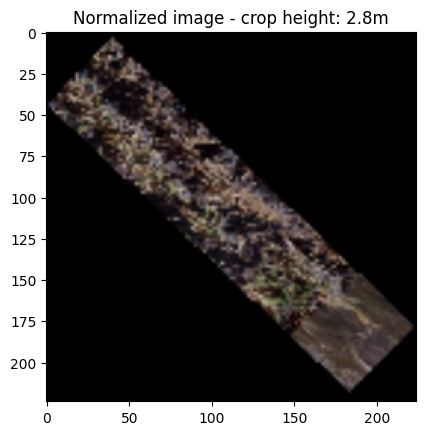

In [15]:
plt.imshow(curr_dataset['dataset'][0][0].permute(1,2,0))
plt.title("Normalized image - crop height: " + str(curr_dataset['dataset'][0][1])+ "m")
plt.show()

Text(0.5, 1.0, 'Distribution of pixels')

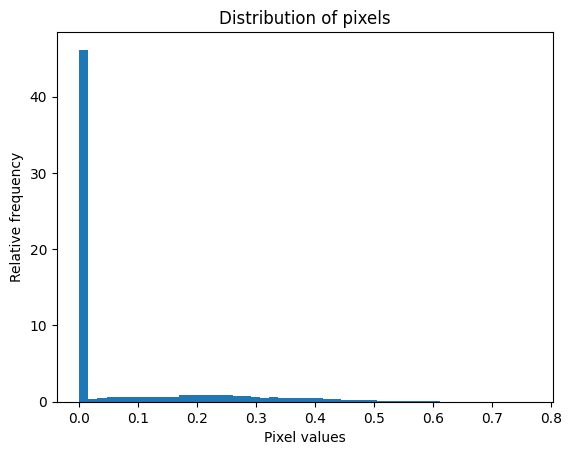

In [16]:
# Pixel distribution
plt.hist(curr_dataset['dataset'][0][0].permute(1,2,0).ravel(), bins=50, density=True)
plt.xlabel("Pixel values")
plt.ylabel("Relative frequency")
plt.title("Distribution of pixels")

#### Split
<a name='split'></a>

In [17]:
dataset = {}
dataset["tmp"], dataset["test"] = train_test_split(curr_dataset["dataset"], test_size=TEST_SIZE)
dataset["train"], dataset["val"] = train_test_split(dataset["tmp"], test_size=VAL_SIZE)

print(f"Training set size: {len(dataset['train'])}")
print(f"Validation set size: {len(dataset['val'])}")
print(f"Test set size: {len(dataset['test'])}")

Training set size: 451
Validation set size: 113
Test set size: 141


In [18]:
def get_labels(dataset, phase):
    # dataset is a dictionary with keys "train", "val", "test"
    # each record in the dataset is a tuple of (image, label)
    labels = [x[1] for x in dataset[phase]]
    return labels

phases = ["train", "val", "test"]
labels = {}
labels = {phase: get_labels(dataset, phase) for phase in phases}

print(f"Training set labels size: {len(labels['train'])}")
print(f"Validation set labels size: {len(labels['val'])}")
print(f"Test set labels size: {len(labels['test'])}")


Training set labels size: 451
Validation set labels size: 113
Test set labels size: 141


### DataLoaders
<a name="dataloader"></a>

In [19]:
dataloader = {}
dataloader["train"] = DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
dataloader["val"] = DataLoader(dataset["val"], batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
dataloader["test"] = DataLoader(dataset["test"], batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

print(f"Train Dataloader size: {len(dataloader['train'])}")
print(f"Validation Dataloader size: {len(dataloader['val'])}")
print(f"Test Dataloader size: {len(dataloader['test'])}")

Train Dataloader size: 15
Validation Dataloader size: 4
Test Dataloader size: 5


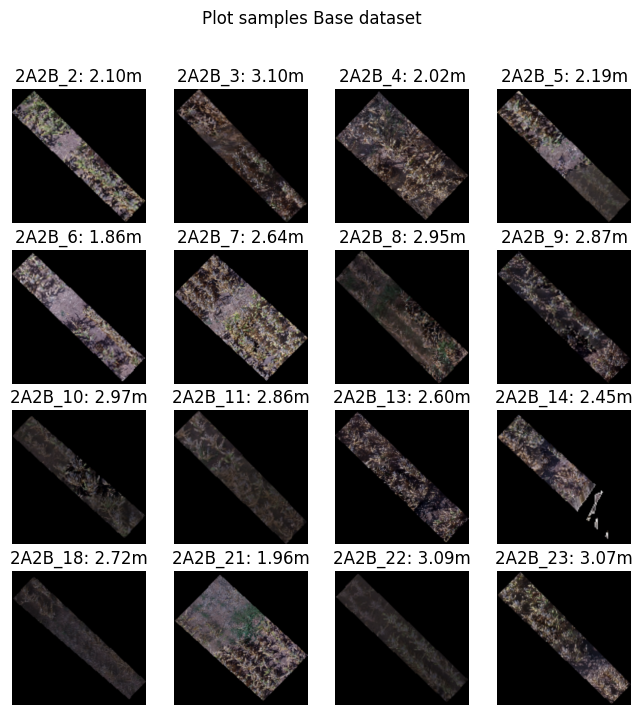

In [20]:
get_dataset_samples(base_dataset["dataset"], "Base dataset")

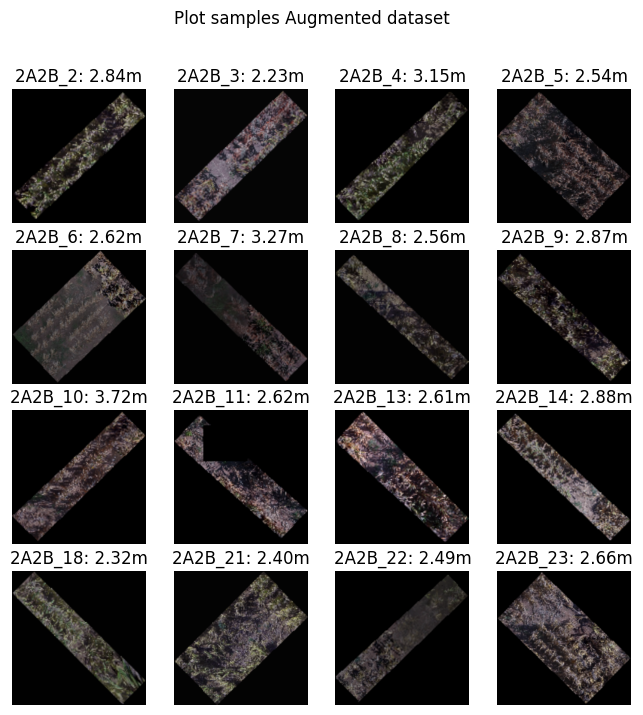

In [21]:
get_dataset_samples(augmented_dataset["dataset"], "Augmented dataset")

#### Model
<a name='model'></a>

In [22]:
# Load the ViT model
backbone = get_model(modelName, weights=weights)
loss_fn = TF.mse_loss

model = UAV_vit(backbone, loss_fn, labels)

In [23]:
mlflow.log_params({"model": modelName, "weights": weights})

## Training
<a name='training'></a>

In [24]:
# from lightning.pytorch import Trainer
# from lightning.pytorch.loggers import MLFlowLogger
# mlf_logger = MLFlowLogger(experiment_name="lightning_logs", tracking_uri="file:./mlruns")

earlyStopping = EarlyStopping(monitor="val_loss", patience=3, mode="min")
log_every_n_steps = 1

# Initialize a trainer
trainer = pl.Trainer(
    log_every_n_steps=log_every_n_steps,
    # default_root_dir=MODEL_PATH,
    max_epochs=TRAIN_EPOCS,
    # callbacks=[earlyStopping],
    num_sanity_val_steps=0,
    enable_checkpointing=False
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
d:\Repository\UAV_ViT\venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them

In [25]:
# Training
trainer.fit(model, dataloader["train"], dataloader["val"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | VisionTransformer | 305 M 
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | test_metrics  | MetricCollection  | 0     
----------------------------------------------------
305 M     Trainable params
0         Non-trainable params
305 M     Total params
1,222.046 Total estimated model params size (MB)


Epoch 99: 100%|██████████| 15/15 [03:18<00:00, 13.23s/it, v_num=2]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 15/15 [03:18<00:00, 13.23s/it, v_num=2]


2023/09/23 23:12:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/09/23 23:13:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Thuls\AppData\Local\Temp\tmppncm5xy9\model\data, flavor: pytorch), fall back to return ['torch==2.0.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/09/23 23:13:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Repository\UAV_ViT\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [26]:
# Save the trained model
# torch.save(model.state_dict(), MODEL_PATH + "uav_vit.pt")

#### Evaluation
<a name='prediction'></a>

In [27]:
# Testing
trainer.test(model, dataloader["test"], verbose=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MeanAbsoluteError   │    0.2316322922706604     │
│   test_MeanSquaredError   │    0.08735095709562302    │
│       test_R2Score        │    0.03013119474053383    │
│         test_loss         │    0.08735095709562302    │
└───────────────────────────┴───────────────────────────┘

[{'test_MeanSquaredError': 0.08735095709562302,
  'test_MeanAbsoluteError': 0.2316322922706604,
  'test_R2Score': 0.03013119474053383,
  'test_loss': 0.08735095709562302}]

In [28]:
mlflow.log_param("log_every_n_steps", log_every_n_steps)
mlflow.log_artifact("main.ipynb")
mlflow.log_artifact("notebooks/uav_vit.ipynb")
mlflow.end_run()

In [29]:
import logging

logging.getLogger("mlflow").setLevel(logging.DEBUG)

## Prediction

In [30]:
# model = UAV_vit.load_from_checkpoint("best_model.ckpt")
# model.freeze()

# x = test_dataset[0][0]
# predicition = model(x)

In [31]:
img = curr_dataset["dataset"][0][0]
predicted = model(img.unsqueeze(0)).item()

print(f"Actual result {curr_dataset['dataset'][0][1]} predicted result {predicted}")

Actual result 2.799999952316284 predicted result 2.930037498474121
